# Deconfounded Recommender

Dataset - Amazon Reviews Dataset

Author - Mahima

# Baseline Model - Probabilistic Matrix Factorization (PMF)



In [86]:
import os
import sys
import pickle
import warnings
import numpy as np 
import pandas as pd 
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split

randseed = 29266137


download the dataset and unzip it for further use.

In [87]:
os.environ['KAGGLE_USERNAME'] = "mahimagaur3131" # username from the json file
os.environ['KAGGLE_KEY'] = "f283ab784cb9afd472c90766acabc801" # key from the json file

#Movies Dataset
# ! kaggle datasets download -d saurav9786/amazon-product-reviews
# !unzip amazon-product-reviews.zip

#Amazon Reviews Dataset
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews")
# !unzip amazon-product-reviews.zip

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Skipping, found downloaded files in "./amazon-product-reviews" (use force=True to force download)


In [88]:
colnames=['userId', 'itemId', 'rating', 'timestamp'] 
pwd = os.getcwd()
df = pd.read_csv(pwd+'/amazon-product-reviews/ratings_Electronics (1).csv', names=colnames, header=None)
print(df.shape)
_, df = train_test_split(df, test_size=0.001, random_state=randseed)
df = df[['userId', 'itemId', 'rating']]
print(df.shape)


(7824482, 4)
(7825, 3)


Prepare the sparse review matrix R.

In [89]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    items_to_column = {}
    df_values = df.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 0])
    uniq_items = np.unique(df_values[:, 1])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, item_id in enumerate(uniq_items):
        items_to_column[item_id] = j
    
    n_users = len(uniq_users)
    n_items = len(uniq_items)
    
    R = np.zeros((n_users, n_items))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = items_to_column[row.itemId]
        R[i, j] = row.rating

    return R, train_set, test_set, n_dims, n_users, n_items, user_to_row, items_to_column

Let's now call this function and retrieve all necessary parameters.

In [90]:
R, train_set, test_set, n_dims, n_users, n_items, user_to_row, item_to_column = get_ratings_matrix(df, 0.8)
parameters = {}

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [91]:
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_items))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [92]:
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_items):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

Now let's implement the Log-a posteriori:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [93]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [94]:
def predict(user_id, item_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, item_to_column[item_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [95]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['itemId']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

For the purposes of scaling, we need the maximum and minimum rating values.

In [96]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [102]:
def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train = []
    rmse_test = []
    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

Let's train our model!

In [103]:
log_ps, rmse_train, rmse_test = train(150)

Log p a-posteriori at iteration 10 : -6649.741005952103
Log p a-posteriori at iteration 20 : -6553.875630932693
Log p a-posteriori at iteration 30 : -6549.9361119245805
Log p a-posteriori at iteration 40 : -6549.580834192831
Log p a-posteriori at iteration 50 : -6549.539175275028
Log p a-posteriori at iteration 60 : -6549.533504044123
Log p a-posteriori at iteration 70 : -6549.532515543359
Log p a-posteriori at iteration 80 : -6549.532245121985
Log p a-posteriori at iteration 90 : -6549.532135529434
Log p a-posteriori at iteration 100 : -6549.532084243101
Log p a-posteriori at iteration 110 : -6549.5320598834705
Log p a-posteriori at iteration 120 : -6549.532048508367
Log p a-posteriori at iteration 130 : -6549.532043296707
Log p a-posteriori at iteration 140 : -6549.532040944373
Log p a-posteriori at iteration 150 : -6549.532039893958


Now let's take a look at some graphs

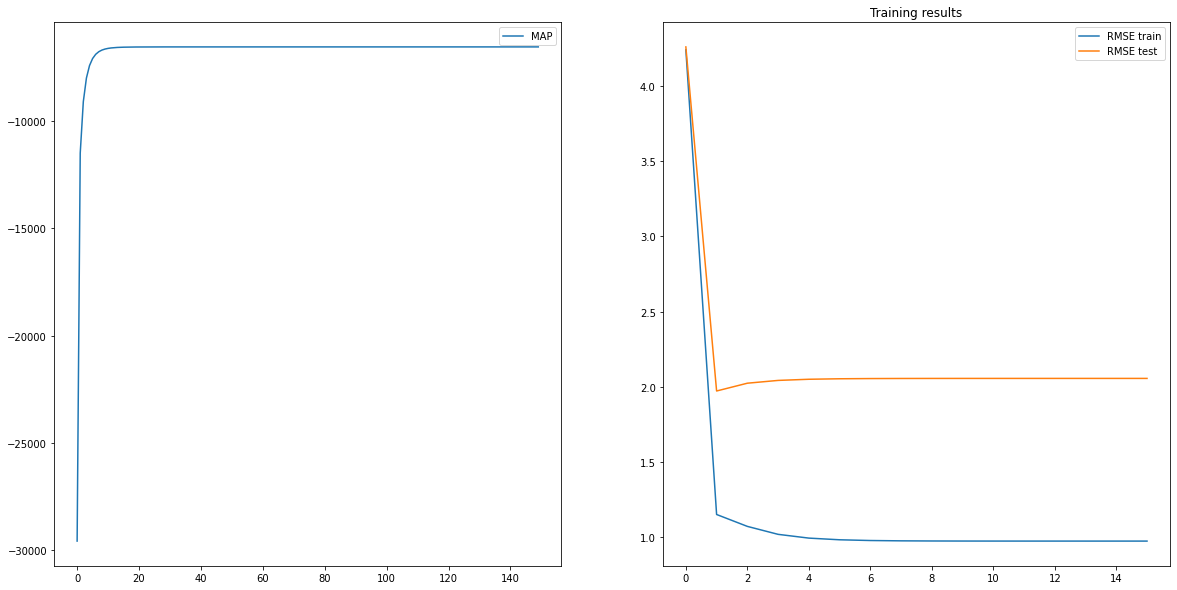

In [104]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

Let's now evaluate our model on both the training and testing sets.

In [106]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 0.9761051302411172
RMSE of testing set: 2.056411658558598


# The Deconfounder in Action



Poisson Matrix Factorization  - The Exposure Model

Preparing the exposure data.

In [107]:
def exposure_data(df, train_size=0.75):
    user_to_row = {}
    item_to_column = {}
    
    uniq_users = np.unique(df['userId'])
    uniq_items = np.unique(df['itemId'])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, item_id in enumerate(uniq_items):
        item_to_column[item_id] = j
    
    data = []
    n_users = len(uniq_users)
    n_items = len(uniq_items)
    for row in df.iterrows():
      user, item = row[1][0], row[1][1]
      data.append((user_to_row[user], item_to_column[item], 1))

    exposure_df = pd.DataFrame(data, columns =['userID', 'itemID', 'a'])
    #Train-test split
    df_copy = exposure_df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    return exposure_df, train_set, test_set, n_users, n_items, user_to_row, item_to_column


exposure_df, train, test, n_users, n_items, user_to_row, item_to_column = exposure_data(df)

Step 1 - Fit the exposure model

In [108]:
! pip install hpfrec
import pandas as pd, numpy as np
from hpfrec import HPF
exposure_df.columns = ['UserId', 'ItemId', 'Count']
recommender = HPF()
param = recommender.fit(exposure_df)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 7811
Number of items: 6506
Latent factors to use: 30

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -101553 | train rmse: 0.9990
Iteration 20 | train llk: -101600 | train rmse: 0.9989
Iteration 30 | train llk: -101404 | train rmse: 0.9988
Iteration 40 | train llk: -101396 | train rmse: 0.9988
Iteration 50 | train llk: -101395 | train rmse: 0.9988
Iteration 60 | train llk: -101394 | train rmse: 0.9988
Iteration 70 | train llk: -101393 | train rmse: 0.9988
Iteration 80 | train llk: -101393 | train rmse: 0.9988
Iteration 90 | train llk: -101394 | train rmse: 0.9988
Iteration 100 | train llk: -101394 | tr

Some data preprocessing

In [109]:
def matrix_X(R):
  X = []
  for i in range(len(R)):
    row = [1 if val == 1 else 0 for val in R[i]]
    X.append(row)
  return X

X = matrix_X(R)
ratings = df['rating']
y = R
pmfU = param.Theta

y_scaler = preprocessing.StandardScaler().fit(y)
y_scaled = y_scaler.fit_transform(y)

X_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = X_scaler.fit_transform(X)

pmfU_scaler = preprocessing.StandardScaler().fit(pmfU)
pmfU_scaled = pmfU_scaler.fit_transform(pmfU)

X_train, X_test = train_test_split(X_scaled, test_size=0.20, random_state=randseed)
y_train, y_test = train_test_split(y_scaled, test_size=0.20, random_state=randseed)
pmfU_train, pmfU_test = train_test_split(pmfU_scaled, test_size=0.20, random_state=randseed)
n_users, n_items = X_train.shape

Step 2 - Fit the outcome model

In [110]:
import warnings
warnings.filterwarnings('ignore')
reg = linear_model.Ridge(normalize=True)
for i in range(n_items):
#     if i%100 == 0:
#       print('---- Fitting row', i, '----')
    reg.fit(np.column_stack([X_train[:,i], pmfU_train]), y_train[:,i])

Step 4 - Estimate potential ratings

In [111]:
test_items = X_test.shape[1]
prediction = []

for i in range(test_items):
#     if i%100 == 0:
#       print('---- Predicting row', i, '----')
    res = reg.predict(np.column_stack([X_test[:,i], pmfU_test]))
    prediction.append(res)

Evaluate the model

In [112]:
y_test = np.transpose(y_test)
rmse = mean_squared_error(y_test, prediction, squared=False)
print(rmse)

0.7829110024758507


*   Baseline MSE = 2.0
*   Decounder MSE = 0.78


